In [1]:
import os
import cv2
import numpy as np
from skimage import io
import itertools
import pickle
from pprint import pprint
import pandas as pd
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../../src/models")

from predict import CarCountingModel as Model
from evaluate_model import evaluate_model

/opt/conda/envs/py3.6/lib/python3.6/site-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


## Count cars on all test scenes

In [2]:
model_path = "../../models/logs/model_iter_51331"
insize = 128
count_ignore_width=8
car_max = 14
class_num = car_max + 1

mean_path = "../../data/cowc_processed/train_val/crop/mean.npy"
mean = np.load(mean_path)

model = Model(model_path, class_num, insize, mean)

In [3]:
eval_result, scene_info_list = evaluate_model(
    model,
    test_scene_list="../../data/cowc_processed/test/test_scenes.txt", 
    data_root="../../data/cowc/datasets/ground_truth_sets",
    count_ignore_width=count_ignore_width,
    car_max=car_max
)

with open("eval_result.pickle", 'wb') as handle:
    pickle.dump(eval_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("scene_info_list.pickle", 'wb') as handle:
    pickle.dump(scene_info_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading Utah_AGRC/12TVL180140 ... (1/7)


14400 / 14400


Loading Utah_AGRC/12TVL200180 ... (2/7)


14400 / 14400


Loading Utah_AGRC/12TVL240120 ... (3/7)


14400 / 14400


Loading Utah_AGRC/12TVK220980-CROP ... (4/7)


3721 / 3721


Loading Utah_AGRC/12TVL160640-CROP ... (5/7)


4225 / 4225


Loading Utah_AGRC/12TVL160660-CROP ... (6/7)


2809 / 2809


Loading Utah_AGRC/12TVL220360-CROP ... (7/7)


6561 / 6561


In [3]:
#with open("eval_result.pickle", 'rb') as handle:
#  eval_result = pickle.load(handle)

#with open("scene_info_list.pickle", 'rb') as handle:
#  scene_info_list = pickle.load(handle)

## Show evaluation result over all test scenes and at each scene

In [4]:
# Evaluation metrics over all test scenes
pprint(eval_result['metrics'])
pprint(eval_result['cars'])

{'accuracy': 0.9429407098949039,
 'accuracy_1': 0.9878379271597594,
 'accuracy_2': 0.9964472205697666,
 'mae': 0.07657479013814529,
 'proposal_accuracy': 0.974998347544451,
 'rmse': 0.39087854898359736}
{'counted': 19191, 'labeled': 19431}


In [5]:
# Evaluation metrics at each test scene
for scene_info in scene_info_list:
    print(scene_info['scene'])
    pprint(scene_info['eval']['metrics'])
    pprint(scene_info['eval']['cars'])
    print()

Utah_AGRC/12TVL180140
{'accuracy': 0.9834027777777777,
 'accuracy_1': 0.9972222222222222,
 'accuracy_2': 0.9997916666666666,
 'mae': 0.019791666666666666,
 'proposal_accuracy': 0.9893055555555555,
 'rmse': 0.16687486995417322}
{'counted': 925, 'labeled': 806}

Utah_AGRC/12TVL200180
{'accuracy': 0.9806944444444444,
 'accuracy_1': 0.9944444444444445,
 'accuracy_2': 0.998125,
 'mae': 0.029791666666666668,
 'proposal_accuracy': 0.98625,
 'rmse': 0.27550458758027563}
{'counted': 824, 'labeled': 751}

Utah_AGRC/12TVL240120
{'accuracy': 0.8548611111111111,
 'accuracy_1': 0.9724305555555556,
 'accuracy_2': 0.9929166666666667,
 'mae': 0.1832638888888889,
 'proposal_accuracy': 0.9500694444444444,
 'rmse': 0.541025261270981}
{'counted': 12684, 'labeled': 13209}

Utah_AGRC/12TVK220980-CROP
{'accuracy': 0.9416823434560602,
 'accuracy_1': 0.9892502015587208,
 'accuracy_2': 0.9978500403117442,
 'mae': 0.07121741467347487,
 'proposal_accuracy': 0.9645256651437786,
 'rmse': 0.31830307932700985}
{'count

In [6]:
# Ok, wrap these metrics into pandas DataFrame to show them in one table

def rename_keys(metrics, cars):
    
    renamed = {}
    
    renamed['MAE'] = metrics['mae']
    renamed['RMSE'] = metrics['rmse']
    renamed['Accuracy'] = metrics['accuracy']
    renamed['Accuracy ±1'] = metrics['accuracy_1']
    renamed['Accuracy ±2'] = metrics['accuracy_2']
    renamed['Proposal accuracy'] = metrics['proposal_accuracy']
    
    renamed['Labeled'] = cars['labeled']
    renamed['Counted'] = cars['counted']
    
    return renamed


metrics_dict = {}

for scene_info in scene_info_list:
    scene = scene_info['scene']
    metrics_dict[scene] = rename_keys(scene_info['eval']['metrics'], scene_info['eval']['cars'])

metrics_dict['All'] = rename_keys(eval_result['metrics'], eval_result['cars'])


metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df['Error over scene(s) [%]'] = (metrics_df['Counted'] - metrics_df['Labeled']) / metrics_df['Labeled'] * 100.0
metrics_df.sort_index(ascending=True)

metrics_df

,MAE,RMSE,Accuracy,Accuracy ±1,Accuracy ±2,Proposal accuracy,Labeled,Counted,Error over scene(s) [%]
All,0.076575,0.390879,0.942941,0.987838,0.996447,0.974998,19431,19191,-1.235140
Utah_AGRC/12TVK220980-CROP,0.071217,0.318303,0.941682,0.989250,0.997850,0.964526,813,826,1.599016
Utah_AGRC/12TVL160640-CROP,0.151953,0.789277,0.925444,0.968757,0.984379,0.973491,2698,2678,-0.741290
Utah_AGRC/12TVL160660-CROP,0.059096,0.303064,0.953008,0.991100,0.997864,0.974012,608,656,7.894737
Utah_AGRC/12TVL180140,0.019792,0.166875,0.983403,0.997222,0.999792,0.989306,806,925,14.764268
Utah_AGRC/12TVL200180,0.029792,0.275505,0.980694,0.994444,0.998125,0.986250,751,824,9.720373
Utah_AGRC/12TVL220360-CROP,0.031702,0.202860,0.972260,0.996647,0.999543,0.980948,546,598,9.523810
Utah_AGRC/12TVL240120,0.183264,0.541025,0.854861,0.972431,0.992917,0.950069,13209,12684,-3.974563


## Show confusion matrix over all test scenes

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(10, 8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm_orig = cm.copy()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig = plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm_orig[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground-truth car number')
    plt.xlabel('Predicted car number')
    plt.tight_layout()

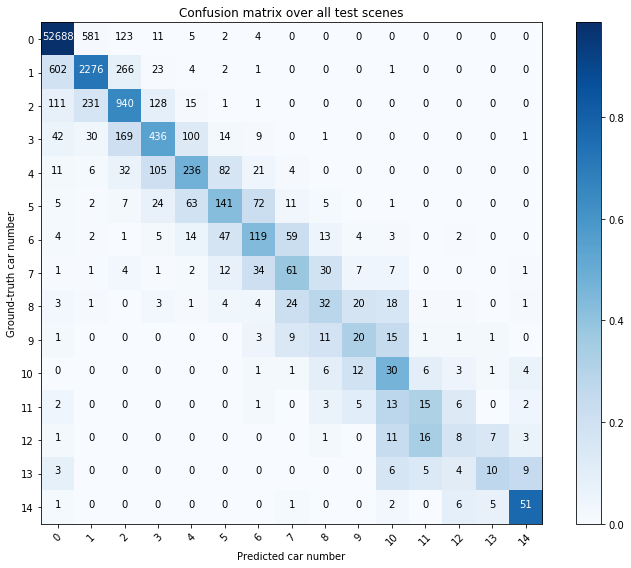

In [8]:
confusion = eval_result['confusion']

plot_confusion_matrix(confusion, np.arange(confusion.shape[0]), title='Confusion matrix over all test scenes')